In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Due to the problem's nature, try to create features that give an idea of the location 
# of passengers during the abnormality

df_train = pd.read_csv("data/train.csv")
df_train = df_train.dropna() # Only for now
df_test = pd.read_csv("data/test.csv")

print("Train shape:", df_train.shape)
print("Test shape:", df_test.shape)
print(df_train.columns)

print()
print(df_train.describe())
print()

print()
print(df_train.dtypes)
print()
# HomePlanet Feature
print("HomePlanet uniques:", df_train["HomePlanet"].unique())
n_HomePlanet_uniques = df_train["HomePlanet"].unique().shape[0]
print("HomePlanet unique count:", n_HomePlanet_uniques)

# Cabin Feature
print("Cabin uniques:", df_train["Cabin"].unique())
n_Cabin_uniques = df_train["Cabin"].unique().shape[0]
print("Cabin unique count:", n_Cabin_uniques)

# Destination Feature
print("Destination uniques:", df_train["Destination"].unique())
n_Destination_uniques = df_train["Destination"].unique().shape[0]
print("Destination unique count:", n_Destination_uniques)
print()

# Attention to 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck' features,
# they looks like to have many outliers

Train shape: (6606, 14)
Test shape: (4277, 13)
Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported'],
      dtype='object')

               Age  RoomService     FoodCourt  ShoppingMall           Spa  \
count  6606.000000  6606.000000   6606.000000   6606.000000   6606.000000   
mean     28.894036   222.991674    478.958523    178.356494    313.161520   
std      14.533429   644.987936   1678.592291    576.328407   1144.016291   
min       0.000000     0.000000      0.000000      0.000000      0.000000   
25%      19.000000     0.000000      0.000000      0.000000      0.000000   
50%      27.000000     0.000000      0.000000      0.000000      0.000000   
75%      38.000000    49.000000     82.750000     30.000000     65.000000   
max      79.000000  9920.000000  29813.000000  12253.000000  22408.000000   

             VRDeck  
count   6606.000000  
mean  

# Analysing: Home -> Destination 

In [11]:
df_groupby = df_train.groupby(by = ["HomePlanet", "Destination"])
groupby_comparation = pd.DataFrame()
for i in df_groupby:
    home_destination = i[0][0]+"_"+i[0][1]
    HD_df = i[1]

    n_HD = HD_df.shape[0]
    transported_HD = HD_df[HD_df["Transported"]==True].shape[0]

    groupby_comparation[home_destination] = [transported_HD / n_HD]
groupby_comparation.index = ["Transported rate"]
print(groupby_comparation.T)

                      Transported rate
Earth_55 Cancri e             0.528986
Earth_PSO J318.5-22           0.503521
Earth_TRAPPIST-1e             0.384301
Europa_55 Cancri e            0.694168
Europa_PSO J318.5-22          0.764706
Europa_TRAPPIST-1e            0.632739
Mars_55 Cancri e              0.631579
Mars_PSO J318.5-22            0.421053
Mars_TRAPPIST-1e              0.503823


# Analysing: Cabin

In [12]:
df_copy = df_train.copy()
df_copy["Cabin"] = df_copy["Cabin"].apply(lambda x: x[0] + x[-1])
df_groupby = df_copy.groupby(by = "Cabin")
groupby_comparation = pd.DataFrame()
for i in df_groupby:
    home_destination = i[0][0]+"_"+i[0][1]
    HD_df = i[1]

    n_HD = HD_df.shape[0]
    transported_HD = HD_df[HD_df["Transported"]==True].shape[0]

    groupby_comparation[home_destination] = [transported_HD / n_HD]
groupby_comparation.index = ["Transported rate"]
print(groupby_comparation.T)

     Transported rate
A_P          0.434783
A_S          0.530435
B_P          0.671329
B_S          0.777778
C_P          0.576336
C_S          0.763077
D_P          0.392857
D_S          0.455056
E_P          0.342424
E_S          0.373938
F_P          0.405797
F_S          0.466603
G_P          0.449949
G_S          0.592480
T_P          0.500000


# Comparing Transported and Not Transported stats

In [14]:
# Comparing Transported and Not Transported dataframes
transported_df = df_train[ df_train["Transported"] == True ]
not_transported_df = df_train[ df_train["Transported"] == False ]

transported_stats = transported_df.describe()
not_transported_stats = not_transported_df.describe()

comparing_df = pd.DataFrame()
comparing_df["T Mean"] = transported_stats.loc["mean"]
comparing_df["NT Mean"] = not_transported_stats.loc["mean"]
comparing_df["T Std"] = transported_stats.loc["std"]
comparing_df["NT Std"] = not_transported_stats.loc["std"]

print(comparing_df)

                  T Mean     NT Mean        T Std       NT Std
Age            27.703036   30.102470    15.266569    13.646138
RoomService    64.658852  383.642269   282.632489   840.194088
FoodCourt     570.646829  385.928027  2028.337287  1218.965709
ShoppingMall  184.993989  171.621836   658.200425   479.178761
Spa            63.484521  566.493443   264.541400  1561.613357
VRDeck         71.105801  539.860323   294.972045  1536.525218


# Analysing the five money features

## RoomService

count    6606.000000
mean        4.550850
std        13.163019
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max       202.448980
Name: RoomService, dtype: float64
RoomService
0    4471
2    1155
1     980
Name: count, dtype: int64


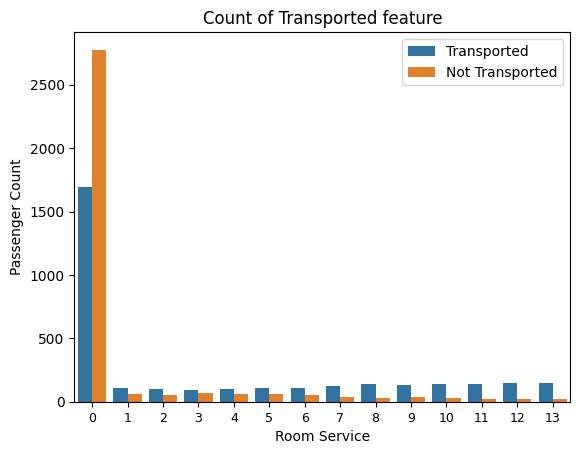

In [103]:
from sklearn.preprocessing import RobustScaler, LabelEncoder

df_copy = df_train.copy()
scaler = RobustScaler()
label_encoder = LabelEncoder()
df_copy["RoomService"] = scaler.fit_transform(np.array(df_copy["RoomService"]).reshape(-1,1))
print(df_copy["RoomService"].describe())
df_copy["RoomService"] = pd.qcut(df_copy["RoomService"], 40, duplicates = "drop")
all_intervals = df_copy["RoomService"].cat.categories


#df_copy["RoomService"] = pd.cut(df_copy["RoomService"], [-1, 0.01, 2.5, 250])

ax = sns.countplot(x='RoomService', hue='Transported', data=df_copy)
plt.xlabel('Room Service')
plt.ylabel('Passenger Count')
plt.legend(["Transported", "Not Transported"])
plt.title("Count of Transported feature")
n_intervals = all_intervals.size
ax.set_xticklabels(range(n_intervals), size = 9)

df_copy["RoomService"] = label_encoder.fit_transform(df_copy["RoomService"])
def final_categories(x):
    if x == 0: 
        return 0

    elif x <= 6:
        return 1

    else:
        return 2
        
df_copy["RoomService"] = df_copy["RoomService"].apply(final_categories)
print(df_copy["RoomService"].value_counts())

## FoodCourt

count    6606.000000
mean        5.788018
std        20.285103
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max       360.277946
Name: FoodCourt, dtype: float64
FoodCourt
0    4324
1    1181
2     550
3     330
4     221
Name: count, dtype: int64


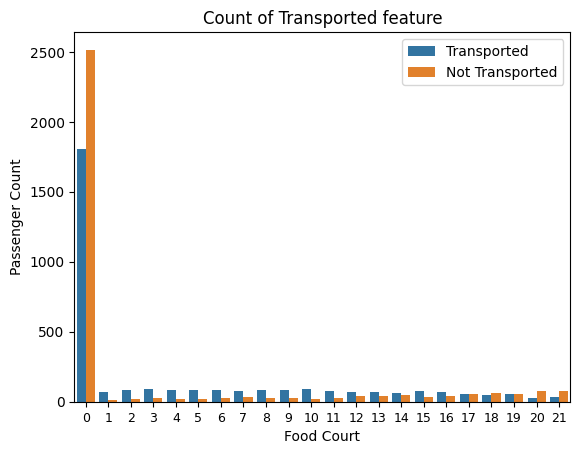

In [104]:
from sklearn.preprocessing import RobustScaler, LabelEncoder

df_copy = df_train.copy()
scaler = RobustScaler()
label_encoder = LabelEncoder()
df_copy["FoodCourt"] = scaler.fit_transform(np.array(df_copy["FoodCourt"]).reshape(-1,1))
print(df_copy["FoodCourt"].describe())
df_copy["FoodCourt"] = pd.qcut(df_copy["FoodCourt"], 60, duplicates = "drop")
all_intervals = df_copy["FoodCourt"].cat.categories



ax = sns.countplot(x='FoodCourt', hue='Transported', data=df_copy)
plt.xlabel('Food Court')
plt.ylabel('Passenger Count')
plt.legend(["Transported", "Not Transported"])
plt.title("Count of Transported feature")
n_intervals = all_intervals.size
ax.set_xticklabels(range(n_intervals), size = 9)

df_copy["FoodCourt"] = label_encoder.fit_transform(df_copy["FoodCourt"])
def final_categories(x):
    if x == 0: 
        return 0

    elif x <= 11:
        return 1

    elif x <= 16:
        return 2

    elif x <= 19:
        return 3
        
    else:
        return 4
        
df_copy["FoodCourt"] = df_copy["FoodCourt"].apply(final_categories)
print(df_copy["FoodCourt"].value_counts())

## ShoppingMall  

count    6606.000000
mean        5.945216
std        19.210947
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max       408.433333
Name: ShoppingMall, dtype: float64
ShoppingMall
0    4462
1    1483
2     440
3     221
Name: count, dtype: int64


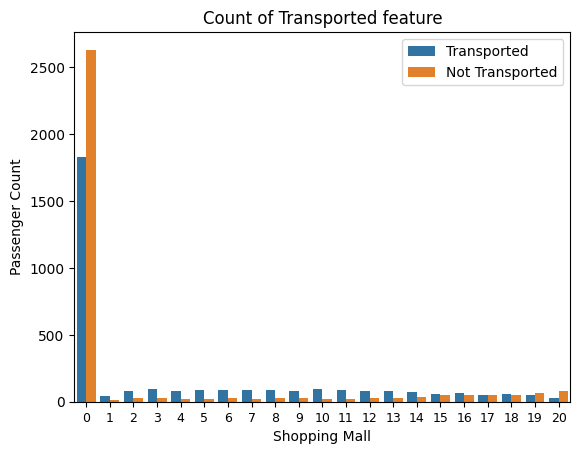

In [105]:
from sklearn.preprocessing import RobustScaler, LabelEncoder

df_copy = df_train.copy()
scaler = RobustScaler()
label_encoder = LabelEncoder()
df_copy["ShoppingMall"] = scaler.fit_transform(np.array(df_copy["ShoppingMall"]).reshape(-1,1))
print(df_copy["ShoppingMall"].describe())
df_copy["ShoppingMall"] = pd.qcut(df_copy["ShoppingMall"], 60, duplicates = "drop")
all_intervals = df_copy["ShoppingMall"].cat.categories



ax = sns.countplot(x='ShoppingMall', hue='Transported', data=df_copy)
plt.xlabel('Shopping Mall')
plt.ylabel('Passenger Count')
plt.legend(["Transported", "Not Transported"])
plt.title("Count of Transported feature")
n_intervals = all_intervals.size
ax.set_xticklabels(range(n_intervals), size = 9)

df_copy["ShoppingMall"] = label_encoder.fit_transform(df_copy["ShoppingMall"])
def final_categories(x):
    if x == 0: 
        return 0

    elif x <= 14:
        return 1

    elif x <= 18:
        return 2
        
    else:
        return 3
        
df_copy["ShoppingMall"] = df_copy["ShoppingMall"].apply(final_categories)
print(df_copy["ShoppingMall"].value_counts())

## Spa

count    6606.000000
mean        4.817870
std        17.600251
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max       344.738462
Name: Spa, dtype: float64
Spa
0    4222
1    1063
2     553
3     547
4     221
Name: count, dtype: int64


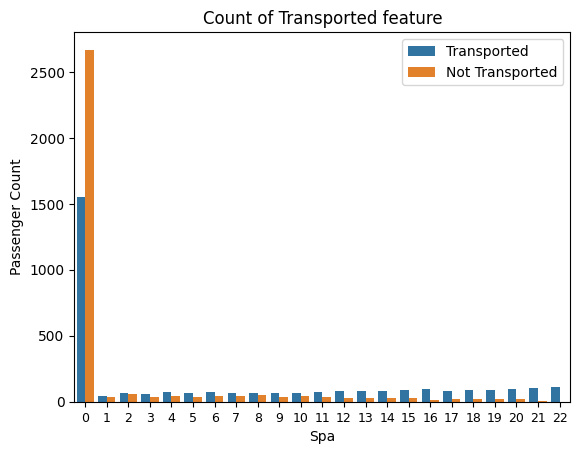

In [107]:
from sklearn.preprocessing import RobustScaler, LabelEncoder

df_copy = df_train.copy()
scaler = RobustScaler()
label_encoder = LabelEncoder()
df_copy["Spa"] = scaler.fit_transform(np.array(df_copy["Spa"]).reshape(-1,1))
print(df_copy["Spa"].describe())
df_copy["Spa"] = pd.qcut(df_copy["Spa"], 60, duplicates = "drop")
all_intervals = df_copy["Spa"].cat.categories



ax = sns.countplot(x='Spa', hue='Transported', data=df_copy)
plt.xlabel('Spa')
plt.ylabel('Passenger Count')
plt.legend(["Transported", "Not Transported"])
plt.title("Count of Transported feature")
n_intervals = all_intervals.size
ax.set_xticklabels(range(n_intervals), size = 9)

df_copy["Spa"] = label_encoder.fit_transform(df_copy["Spa"])
def final_categories(x):
    if x == 0: 
        return 0

    elif x <= 10:
        return 1

    elif x <= 15:
        return 2

    elif x <= 20:
        return 3
        
    else:
        return 4
        
df_copy["Spa"] = df_copy["Spa"].apply(final_categories)
print(df_copy["Spa"].value_counts())

## VRDeck

count    6606.000000
mean        5.841924
std        21.675811
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max       391.076923
Name: VRDeck, dtype: float64
VRDeck
0    4352
1    1483
2     550
3     221
Name: count, dtype: int64


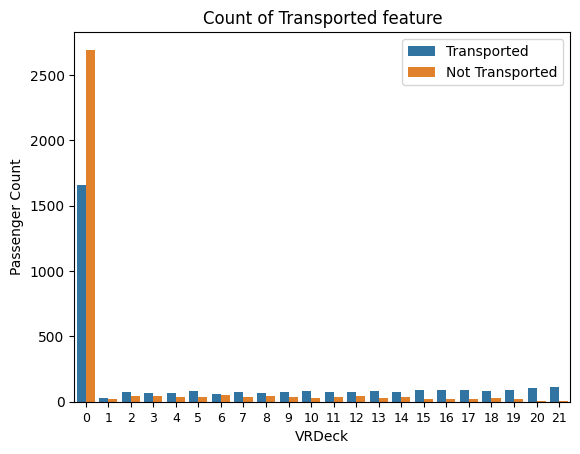

In [109]:
from sklearn.preprocessing import RobustScaler, LabelEncoder

df_copy = df_train.copy()
scaler = RobustScaler()
label_encoder = LabelEncoder()
df_copy["VRDeck"] = scaler.fit_transform(np.array(df_copy["VRDeck"]).reshape(-1,1))
print(df_copy["VRDeck"].describe())
df_copy["VRDeck"] = pd.qcut(df_copy["VRDeck"], 60, duplicates = "drop")
all_intervals = df_copy["VRDeck"].cat.categories



ax = sns.countplot(x='VRDeck', hue='Transported', data=df_copy)
plt.xlabel('VRDeck')
plt.ylabel('Passenger Count')
plt.legend(["Transported", "Not Transported"])
plt.title("Count of Transported feature")
n_intervals = all_intervals.size
ax.set_xticklabels(range(n_intervals), size = 9)

df_copy["VRDeck"] = label_encoder.fit_transform(df_copy["VRDeck"])
def final_categories(x):
    if x == 0: 
        return 0

    elif x <= 14:
        return 1

    elif x <= 19:
        return 2
        
    else:
        return 3
        
df_copy["VRDeck"] = df_copy["VRDeck"].apply(final_categories)
print(df_copy["VRDeck"].value_counts())